In [1]:
import metnum
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from time import time
from pprint import pprint
from Model import Model
from Segment import Segment
from NlpModel import NlpModel

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error as RMSE, mean_squared_log_error as RMSLE, balanced_accuracy_score as BAS, make_scorer
from sklearn.preprocessing import scale, normalize
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier, XGBRegressor

In [2]:
train_df_original = pd.read_csv('../data/train.csv')
train_df = train_df_original.copy()

train_df['urbana'] = (train_df['escuelascercanas'] > 0) & (train_df['centroscomercialescercanos'] > 0 )

train_df.info()
test_df_original = pd.read_csv('../data/test.csv')
test_df = test_df_original.copy()
# test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240000 entries, 0 to 239999
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          240000 non-null  int64  
 1   titulo                      234613 non-null  object 
 2   descripcion                 238381 non-null  object 
 3   tipodepropiedad             239954 non-null  object 
 4   direccion                   186928 non-null  object 
 5   ciudad                      239628 non-null  object 
 6   provincia                   239845 non-null  object 
 7   antiguedad                  196445 non-null  float64
 8   habitaciones                217529 non-null  float64
 9   garages                     202235 non-null  float64
 10  banos                       213779 non-null  float64
 11  metroscubiertos             222600 non-null  float64
 12  metrostotales               188533 non-null  float64
 13  idzona        

In [3]:
# Dropeo las huertas porque solo hay una
train_df = train_df.drop(train_df[train_df['tipodepropiedad'] == 'Huerta'].index)
# Dropeo las quintas vacacionales porque solo los precios son cualquiera
train_df = train_df.drop(train_df[train_df['tipodepropiedad'] == 'Quinta Vacacional'].index)
# Dropeo los ranchos porque solo los precios son cualquiera
train_df = train_df.drop(train_df[train_df['tipodepropiedad'] == 'Rancho'].index)

In [9]:
predict_column = 'precio'
carititud_column = "carititud"
#segments = ['tipodepropiedad', 'usosmultiples', 'banos']
segments = []#'urbana', 'provincia']
text_features = ['titulo', 'descripcion']
features = ['metrostotales', 'metroscubiertos', 'garages']

model1 = NlpModel(train_df, text_features=text_features, features=features, segment_columns=segments)

In [10]:
model1.fit_nlp()

[Pipeline] ............. (step 1 of 3) Processing count, total=   7.2s
[Pipeline] .............. (step 2 of 3) Processing desc, total=  13.5s


/home/awolfsdorf/.pyenv/versions/3.7.5/envs/mettp3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[Pipeline] ............... (step 3 of 3) Processing reg, total= 1.1min


In [11]:
model1.regresionar()

Error calculando metricas en segmento :
Mean Squared Logarithmic Error cannot be used when targets contain negative values.
Error calculando metricas en segmento :
Mean Squared Logarithmic Error cannot be used when targets contain negative values.
Error calculando metricas en segmento :
Mean Squared Logarithmic Error cannot be used when targets contain negative values.


In [12]:
model1.prom_scores()

array([7.30579494e+11, 1.83628312e-01, 1.75169365e-01, 6.20662833e+06])

In [13]:
to_predict = train_df[features + text_features + [predict_column]].dropna()
predicciones = model1.predict(to_predict)

In [16]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

pd.DataFrame(predicciones, to_predict[predict_column])

,0
precio,
2273000.000,2103772.276
3600000.000,4745164.242
1200000.000,2440270.525
650000.000,998387.592
1150000.000,2251958.950
...,...
1650000.000,3913488.291
1350000.000,3279539.322
1940000.000,2869521.116


In [20]:
predict_column = 'precio'
carititud_column = "carititud"
#segments = ['tipodepropiedad', 'usosmultiples', 'banos']
segments = ['urbana']#, 'provincia']
text_features = ['titulo', 'descripcion']
features = []#'metroscubiertos', 'garages']

model2 = NlpModel(train_df, text_features=text_features, features=features, segment_columns=segments)

In [21]:
model2.regresionar()

[Pipeline] ............. (step 1 of 3) Processing count, total=  11.4s
[Pipeline] .............. (step 2 of 3) Processing desc, total=  20.7s


/home/awolfsdorf/.pyenv/versions/3.7.5/envs/mettp3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[Pipeline] ............... (step 3 of 3) Processing reg, total= 1.7min
Error calculando metricas en segmento /False:
Mean Squared Logarithmic Error cannot be used when targets contain negative values.
Error calculando metricas en segmento /False:
Mean Squared Logarithmic Error cannot be used when targets contain negative values.
Error calculando metricas en segmento /False:
Mean Squared Logarithmic Error cannot be used when targets contain negative values.
Error calculando metricas en segmento /False:
Mean Squared Logarithmic Error cannot be used when targets contain negative values.
Error calculando metricas en segmento /False:
Mean Squared Logarithmic Error cannot be used when targets contain negative values.
Error calculando metricas en segmento /True:
Mean Squared Logarithmic Error cannot be used when targets contain negative values.
Error calculando metricas en segmento /True:
Mean Squared Logarithmic Error cannot be used when targets contain negative values.
Error calculando metr

In [22]:
model2.prom_scores()

array([0., 0., 0., 0.])

In [28]:
to_predict = train_df[features + segments + text_features + [predict_column]].dropna()
predicciones = model2.predict(to_predict)

In [44]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

to_show = pd.DataFrame((predicciones, to_predict[predict_column]))


In [56]:
to_show.loc[0].sort_values()

182101   -1050564.380
181490    -554895.513
176913    -525705.468
135573    -426170.079
44409     -416158.081
             ...     
62618    13705231.709
204026   15350717.789
158813   16404323.823
123423   16405438.404
47311    18583155.314
Name: 0, Length: 232712, dtype: float64

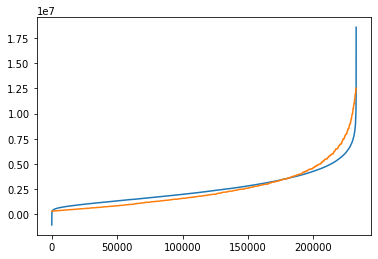

In [63]:
plt.plot(list(range(len(to_show.loc[0]))), to_show.loc[0].sort_values())
plt.plot(list(range(len(to_show.loc[1]))), to_show.loc[1].sort_values())

## De aregresionar en adelante esta el calculo de los metaparametros para la red
---

In [14]:
def sonCaras(precios):
    mean = precios.mean()
    min_val = precios.min()
    max_val = precios.max()
    return np.array([esCara(p, mean, max_val, min_val) for p in precios])
    
def esCara(precio, mean, max_val, min_val):
    if precio > mean:
        if precio > mean + (max_val - mean) / 2:
            return 3
        else:
            return 2
    else:
        if precio > min_val + (mean - min_val) / 2:
            return 1
        else:
            return 0
        
train_df[carititud_column] = sonCaras(df_train[predict_column].values)


## Buscando predecir el precio directamente

In [157]:
vectorizer = CountVectorizer(min_df=3, max_features=5000)
vectorizer.fit(x_train) # Notar que no le muestro el test 

x_train_transf = scale(vectorizer.transform(x_train), with_mean=False)
x_test_transf = scale(vectorizer.transform(x_test), with_mean=False)

In [158]:
# Saco componentes principales
tsvd = TruncatedSVD(100)
tsvd.fit(x_train_transf)

TruncatedSVD(n_components=100)

In [159]:
x_train_transf = tsvd.transform(x_train_transf)
x_test_transf = tsvd.transform(x_test_transf)

In [160]:
tsvd.explained_variance_.sum()

741.9866979147752

In [135]:
regr = MLPRegressor(
    solver='sgd', learning_rate='adaptive', early_stopping=True,
    hidden_layer_sizes=(100,200,50), max_iter=200, random_state=1, verbose=True)
regr.fit(x_train_transf, y_train)

Iteration 1, loss = 0.51546139
Validation score: -0.039834
Iteration 2, loss = 0.44509959
Validation score: -0.008313
Iteration 3, loss = 0.43801872
Validation score: -0.005355
Iteration 4, loss = 0.43694414
Validation score: -0.003124
Iteration 5, loss = 0.43620054
Validation score: -0.002753
Iteration 6, loss = 0.43584307
Validation score: -0.002084
Iteration 7, loss = 0.43568954
Validation score: -0.002472
Iteration 8, loss = 0.43561472
Validation score: -0.002264


/home/awolfsdorf/.pyenv/versions/3.7.5/envs/mettp3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPRegressor(early_stopping=True, hidden_layer_sizes=(100, 200, 50),
             learning_rate='adaptive', random_state=1, solver='sgd',
             verbose=True)

In [136]:
regr.loss_

0.435614723929101

In [64]:
print(regr.score(x_train_transf, y_train))
print(regr.score(x_test_transf, y_test))

0.07693442191101652
-0.022941062631672837


In [65]:
real = y_test
predicted = regr.predict(x_test_transf)
err = RMSE(predicted, real)
print("{:.2E}".format(err))
to_show = pd.DataFrame()
pd.set_option('display.float_format', lambda x: '%.3f' % x)
to_show["real"] = real
to_show["pred"] = predicted
to_show

1.01E+00


,real,pred
0,0.539,1.072
1,0.214,0.951
2,0.330,0.940
3,0.097,0.945
4,0.309,1.242
...,...,...
1995,0.214,0.892
1996,0.283,1.070
1997,0.701,1.013
1998,0.840,1.083


In [137]:
sgd = SGDClassifier()
sgd.fit(x_train_transf, y_train)

SGDClassifier()

In [138]:
sgd.score(x_train_transf, y_train)

0.30765479486534103

In [139]:
sgd.score(x_test_transf, y_test)

0.30691947899406424

## Probando con Clasificadores

In [28]:

# A parameter grid for the pipeline
params = {
    # Bag of Words
    'count__min_df': [2, 5, 10],
    'count__max_features': [200, 500, 1000, 5000],

    # Descompositer
    'desc__n_components': [100, 500, 1000],

    # Classificator
    'clf__min_child_weight': [1, 5, 10],
    'clf__gamma': [0.5, 1, 1.5, 2, 5],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__colsample_bytree': [0.6, 0.8, 1.0],
    'clf__max_depth': [3, 5, 7, 10],
    'clf__learning_rate': [0.01, 0.02, 0.05]    
}

folds = 3
param_comb = 1

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)


xgb = XGBClassifier(learning_rate=0.02, n_estimators=1000, 
                    silent=True, nthread=6, tree_method='gpu_hist')

pipeline = Pipeline([
    ('count', CountVectorizer()),
    ('desc', TruncatedSVD()),
    ('clf', xgb)
])

random_search = RandomizedSearchCV(
    pipeline, param_distributions=params, n_iter=param_comb, scoring=make_scorer(BAS), 
    n_jobs=-1, cv=skf.split(x_train,y_train), random_state=1001
)


## Resultado 
best_params = {
    'clf__colsample_bytree': 0.6,
    'clf__gamma': 2,
    'clf__learning_rate': 0.05,
    'clf__max_depth': 7,
    'clf__min_child_weight': 10,
    'clf__subsample': 1.0,
    'count__max_features': 1000,
    'count__min_df': 5,
    'desc__n_components': 100
}

In [29]:
random_search.fit(x_train[:100], y_train[:100])

[15:31:35] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7ff824009c50>,
                   estimator=Pipeline(steps=[('count', CountVectorizer()),
                                             ('tfid', TfidfTransformer()),
                                             ('clf',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            gamma=None,
                                                            gpu_id=None,
                                                            importance_type='gain',
                                                            interaction_constraints=None,


In [188]:
estimator = random_search.best_estimator_

In [ ]:
estimator.fit(x_train, y_train)

In [190]:
estimator.score(x_test, y_test)

0.37900874635568516

In [119]:
random_search.best_estimator_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

In [114]:
real = y_test
predicted = estimator.predict(x_test)
err = RMSE(predicted, real)
print("{:.2E}".format(err))
to_show = pd.DataFrame()
pd.set_option('display.float_format', lambda x: '%.3f' % x)
to_show["real"] = real
to_show["pred"] = predicted
to_show[to_show["pred"]==3]

1.92E+00


,real,pred
30578,1,3


In [ ]:
# A parameter grid for the pipeline
params = {
    # Bag of Words
    'count__min_df': [2, 5, 10],
    'count__max_features': [200, 500, 1000, 5000],

    # Descompositer
    'desc__n_components': [100, 500, 1000],

    # Classificator
    'reg__solver': ['sgd', 'adam'],
    'reg__max_iter': [50, 100],
    'reg__hidden_layer_sizes': [(100,), (50,20), (50)]  
}

folds = 3
param_comb = 1

# Uso KFold porque son valores continuos
kf = KFold(n_splits=folds, shuffle=True, random_state = 1001)

pipeline_reg = Pipeline([
    ('count', CountVectorizer()),
    ('desc', TruncatedSVD()),
    ('reg', MLPRegressor())
])

random_search_reg = RandomizedSearchCV(
    pipeline_reg, param_distributions=params, n_iter=param_comb, scoring='neg_mean_squared_error', 
    n_jobs=-1, cv=kf.split(x_train, y_train_scaled), random_state=1001, verbose=3
)